In [4]:
import logging

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from pathlib import Path

import sys
import os

# to allow importing `reproduction` from parent directory
sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath("./train.ipynb"))))

# from config import logger  # noqa: E402
from data_handling import CustomSpectralPipeline, load_data  # type: ignore  # noqa: E402
from reproduction import (  # noqa: E402
    major_oxides,
    masks,
    oxide_ranges,
    paper_individual_sm_rmses,
)  # noqa: E402
from utils import (  # noqa: E402
    custom_kfold_cross_validation,
    custom_train_test_split,
    filter_data_by_compositional_range,
)

logger = logging.getLogger("train")

mlflow.set_tracking_uri("http://localhost:5000")

dataset_loc = Path("../data/data/calib/calib_2015/1600mm/pls/")
calib_loc = Path("../data/data/calib/ccam_calibration_compositions.csv")
take_samples = None

In [5]:
logger.info("Loading data from location: %s", dataset_loc)
data = load_data(str(dataset_loc), take_samples)
logger.info("Data loaded successfully.")

Loading data: 100%|██████████| 414/414 [03:14<00:00,  2.13it/s]


In [6]:
logger.info("Initializing CustomSpectralPipeline.")
pipeline = CustomSpectralPipeline(
    masks=masks,
    composition_data_loc=calib_loc,
    major_oxides=major_oxides,
)
logger.info("Pipeline initialized. Fitting and transforming data.")
processed_data = pipeline.fit_transform(data)
logger.info("Data processing complete.")

Transforming samples: 100%|██████████| 414/414 [00:38<00:00, 10.83it/s]


2023/12/05 14:55:39 INFO mlflow.tracking.fluent: Experiment with name 'PLS_Models_12-05-23_145539' does not exist. Creating a new experiment.
Processing oxides:   0%|          | 0/8 [00:00<?, ?it/s]2023/12/05 14:55:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 14:55:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 14:55:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 14:55:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p

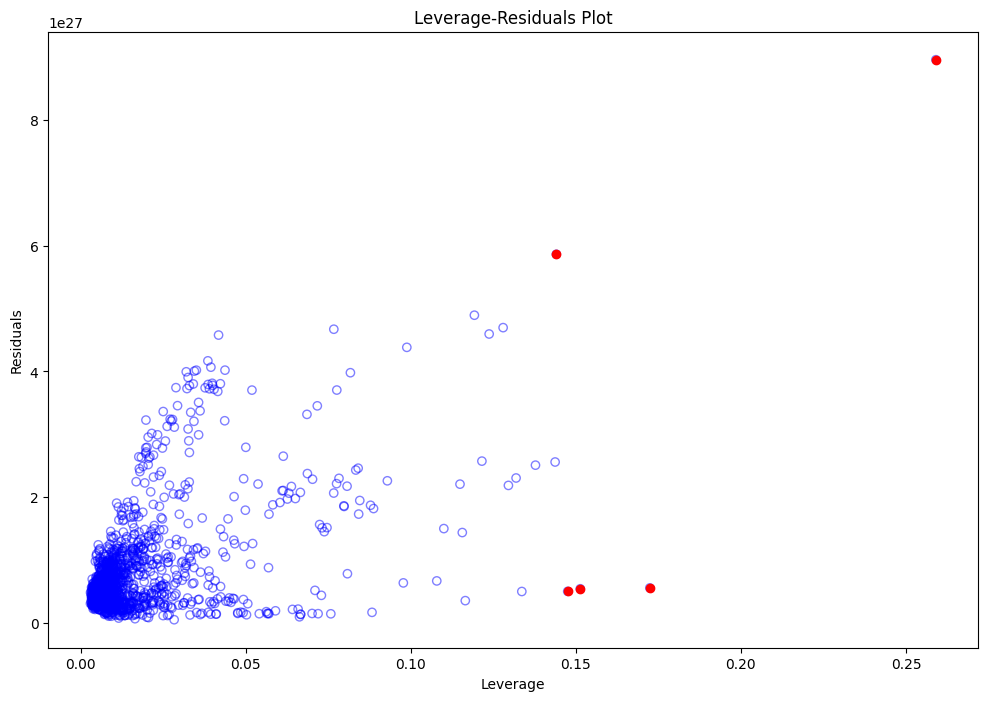

Registered model 'SiO2_Full_outlier_removal' already exists. Creating a new version of this model...
2023/12/05 14:56:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SiO2_Full_outlier_removal, version 2
Created version '2' of model 'SiO2_Full_outlier_removal'.
2023/12/05 14:56:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 14:56:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 14:56:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.

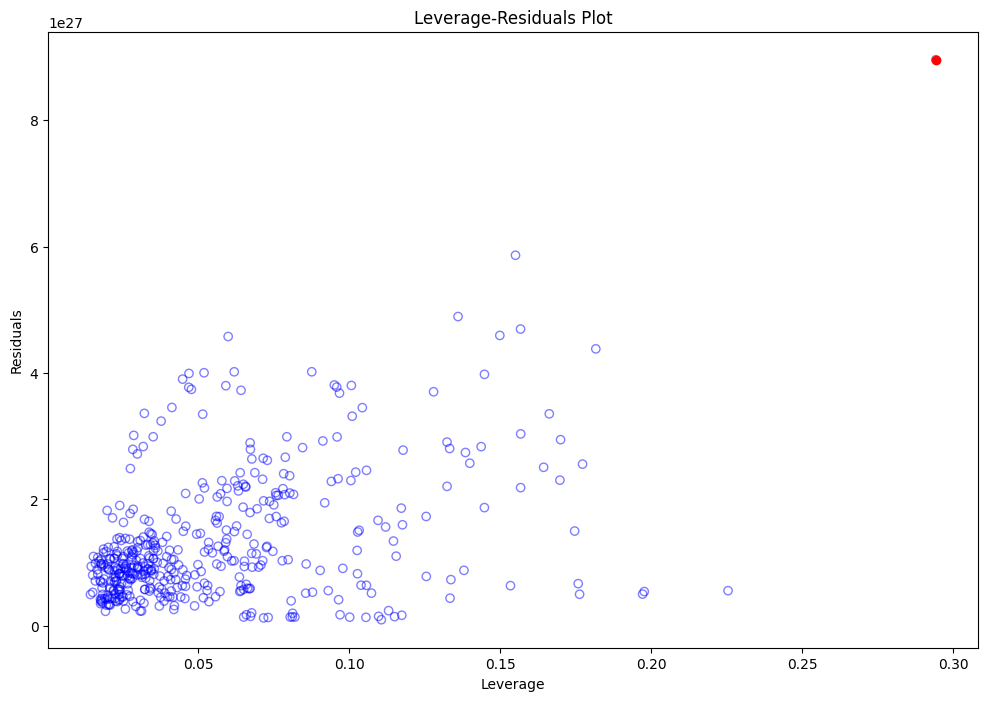

Registered model 'SiO2_Low_outlier_removal' already exists. Creating a new version of this model...
2023/12/05 14:57:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SiO2_Low_outlier_removal, version 2
Created version '2' of model 'SiO2_Low_outlier_removal'.
2023/12/05 14:57:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 14:57:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 14:57:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map

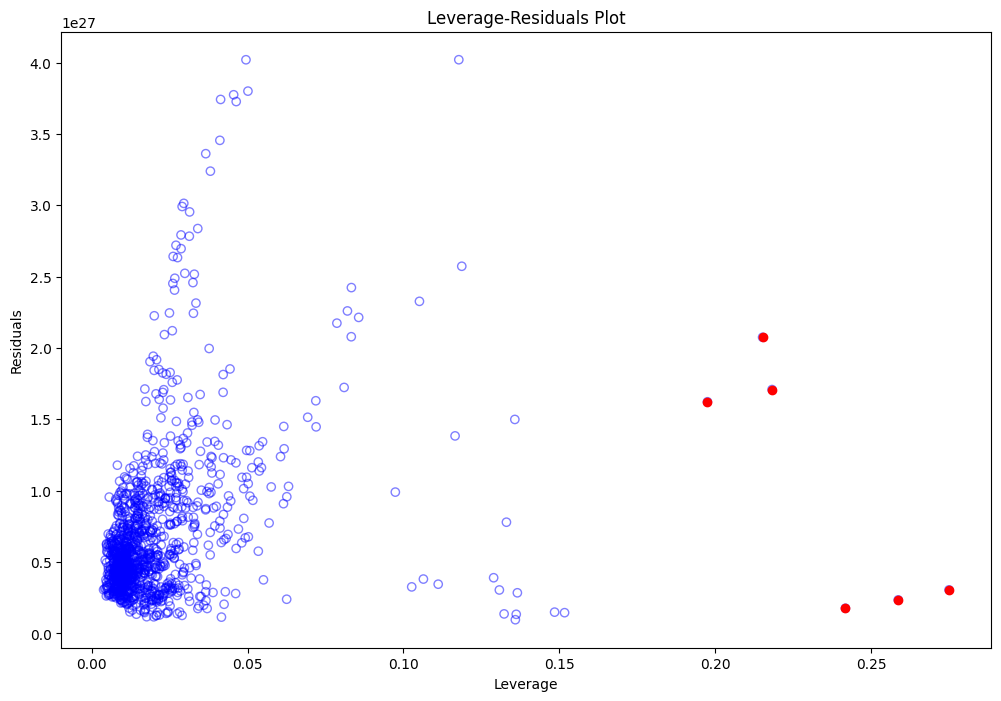

Successfully registered model 'SiO2_Mid_outlier_removal'.
2023/12/05 14:58:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SiO2_Mid_outlier_removal, version 1
Created version '1' of model 'SiO2_Mid_outlier_removal'.
2023/12/05 14:58:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 14:58:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 14:58:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 14:58:34 WARNING mlf

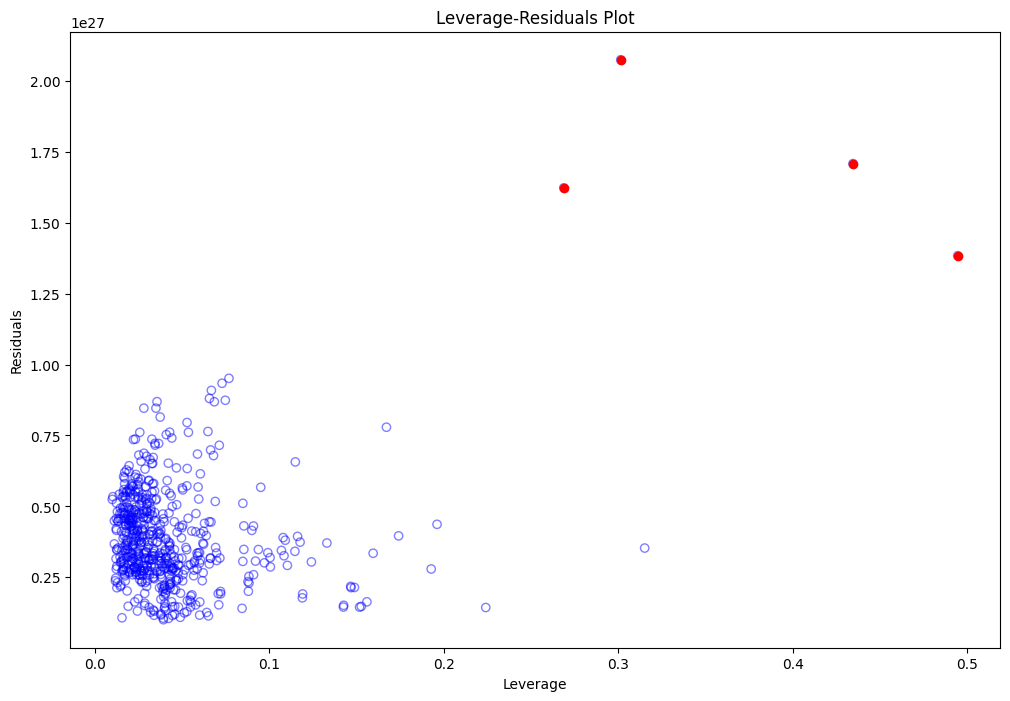

Successfully registered model 'SiO2_High_outlier_removal'.
2023/12/05 14:59:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SiO2_High_outlier_removal, version 1
Created version '1' of model 'SiO2_High_outlier_removal'.
Processing oxides:  12%|█▎        | 1/8 [03:33<24:56, 213.77s/it]2023/12/05 14:59:13 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 14:59:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 14:59:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been dep

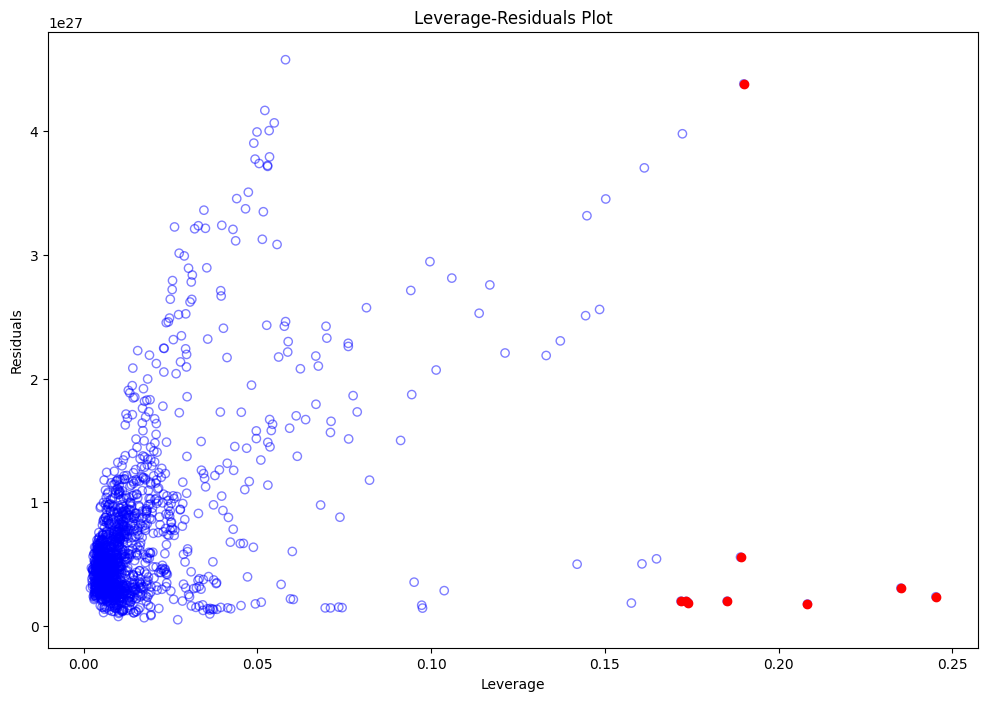

Successfully registered model 'TiO2_Full_outlier_removal'.
2023/12/05 15:00:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: TiO2_Full_outlier_removal, version 1
Created version '1' of model 'TiO2_Full_outlier_removal'.
2023/12/05 15:00:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 15:00:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:00:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:00:27 WARNING 

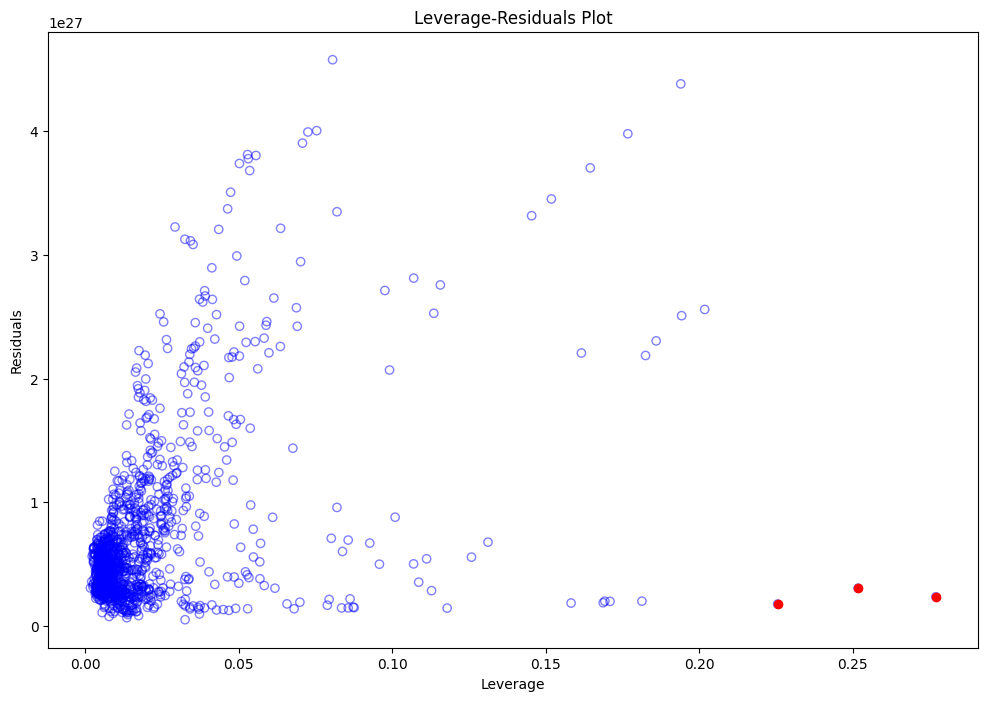

Successfully registered model 'TiO2_Low_outlier_removal'.
2023/12/05 15:01:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: TiO2_Low_outlier_removal, version 1
Created version '1' of model 'TiO2_Low_outlier_removal'.
2023/12/05 15:01:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 15:01:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:01:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:01:23 WARNING mlf

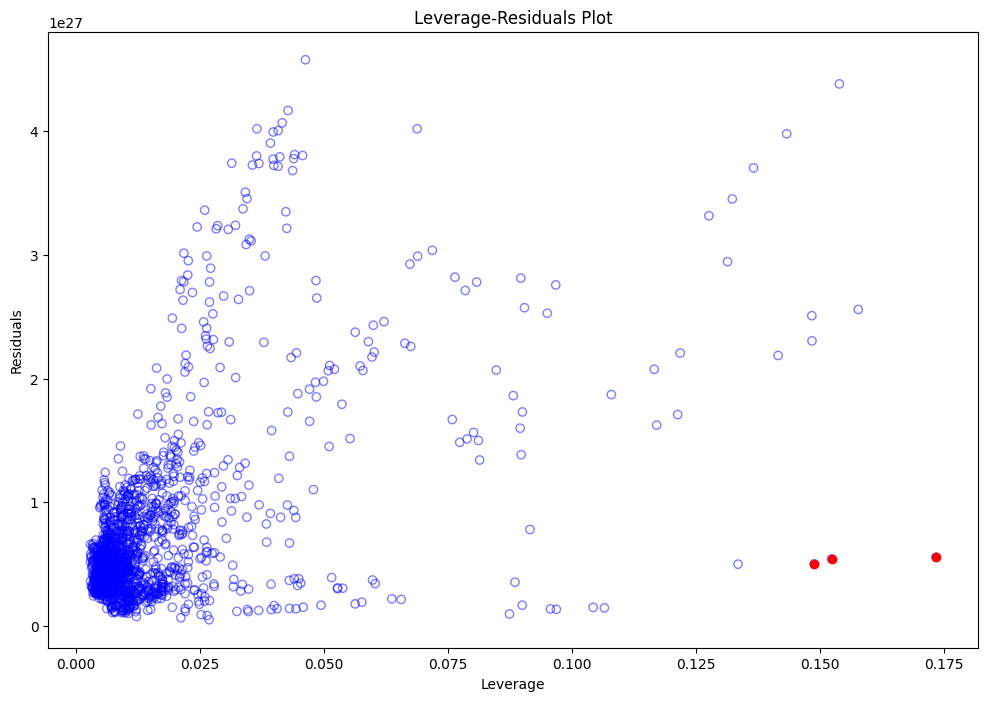

Successfully registered model 'Al2O3_Full_outlier_removal'.
2023/12/05 15:03:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Al2O3_Full_outlier_removal, version 1
Created version '1' of model 'Al2O3_Full_outlier_removal'.
2023/12/05 15:03:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 15:03:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:03:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:03:32 WARNI

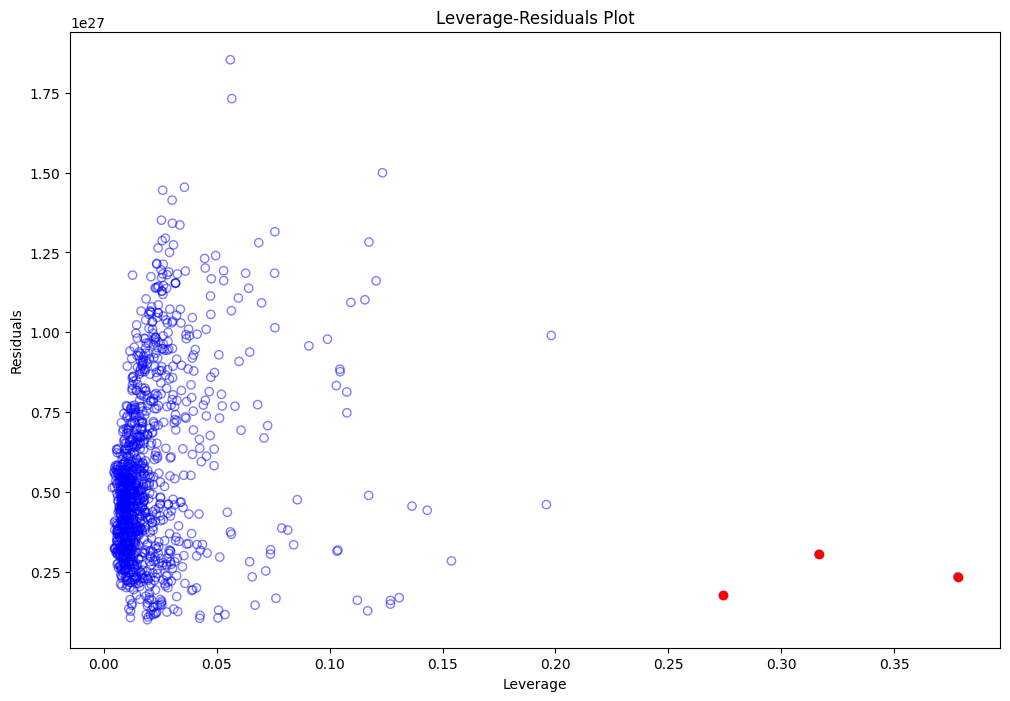

Successfully registered model 'Al2O3_Mid_outlier_removal'.
2023/12/05 15:04:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Al2O3_Mid_outlier_removal, version 1
Created version '1' of model 'Al2O3_Mid_outlier_removal'.
2023/12/05 15:04:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 15:04:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:05:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:05:04 WARNING 

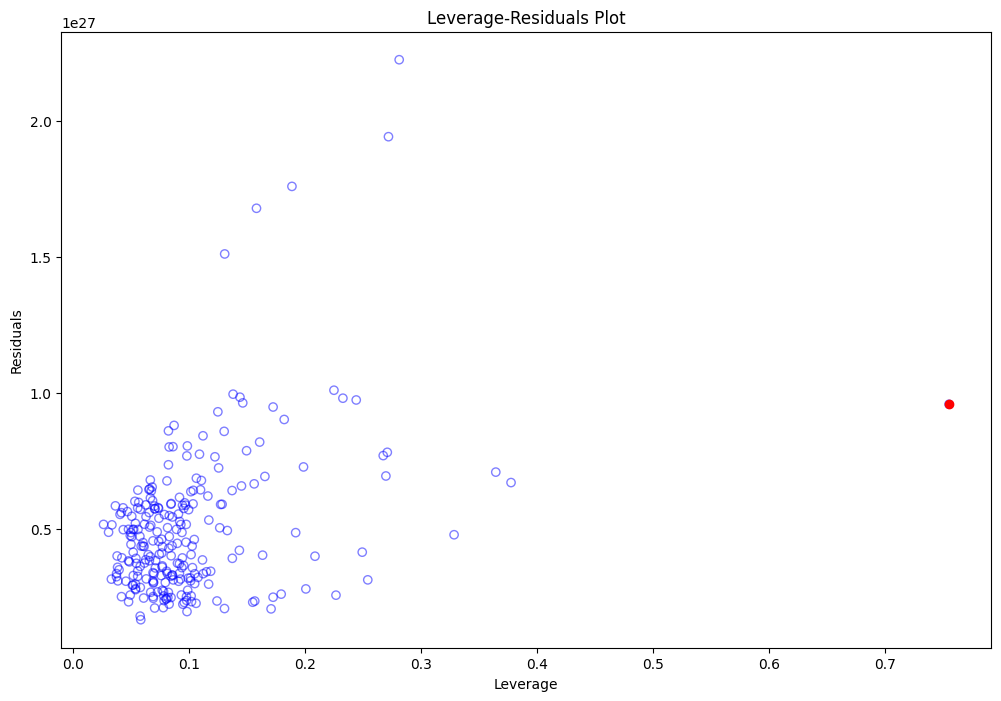

Successfully registered model 'Al2O3_High_outlier_removal'.
2023/12/05 15:05:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Al2O3_High_outlier_removal, version 1
Created version '1' of model 'Al2O3_High_outlier_removal'.
Processing oxides:  38%|███▊      | 3/8 [09:54<16:19, 195.88s/it]2023/12/05 15:05:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 15:05:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:05:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been 

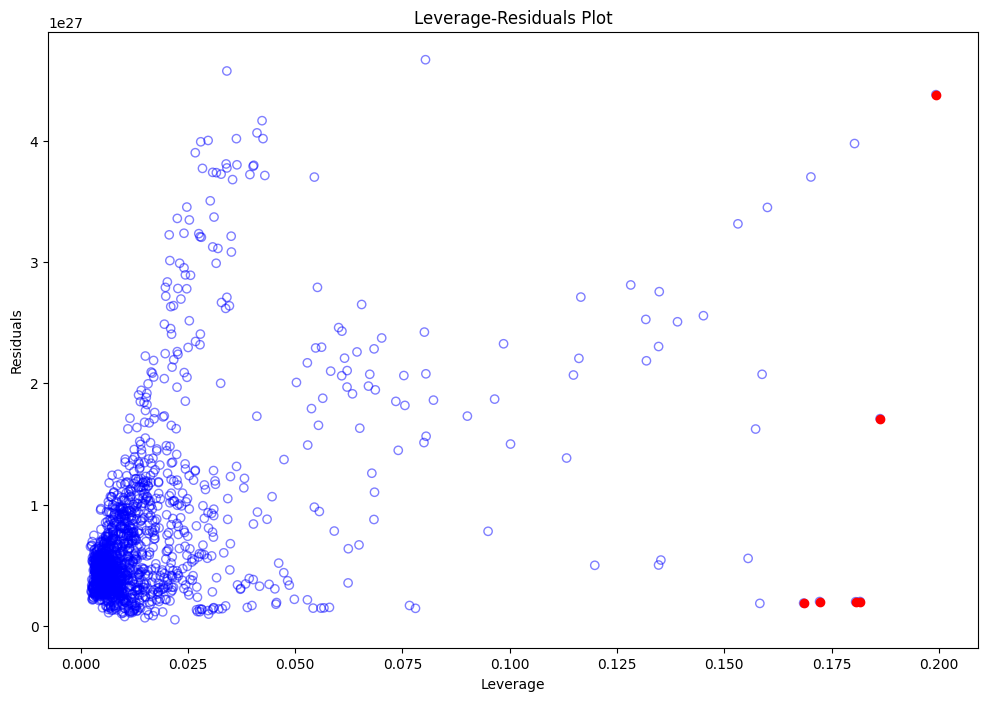

Successfully registered model 'FeOT_Full_outlier_removal'.
2023/12/05 15:06:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: FeOT_Full_outlier_removal, version 1
Created version '1' of model 'FeOT_Full_outlier_removal'.
2023/12/05 15:06:44 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 15:06:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:06:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:06:55 WARNING 

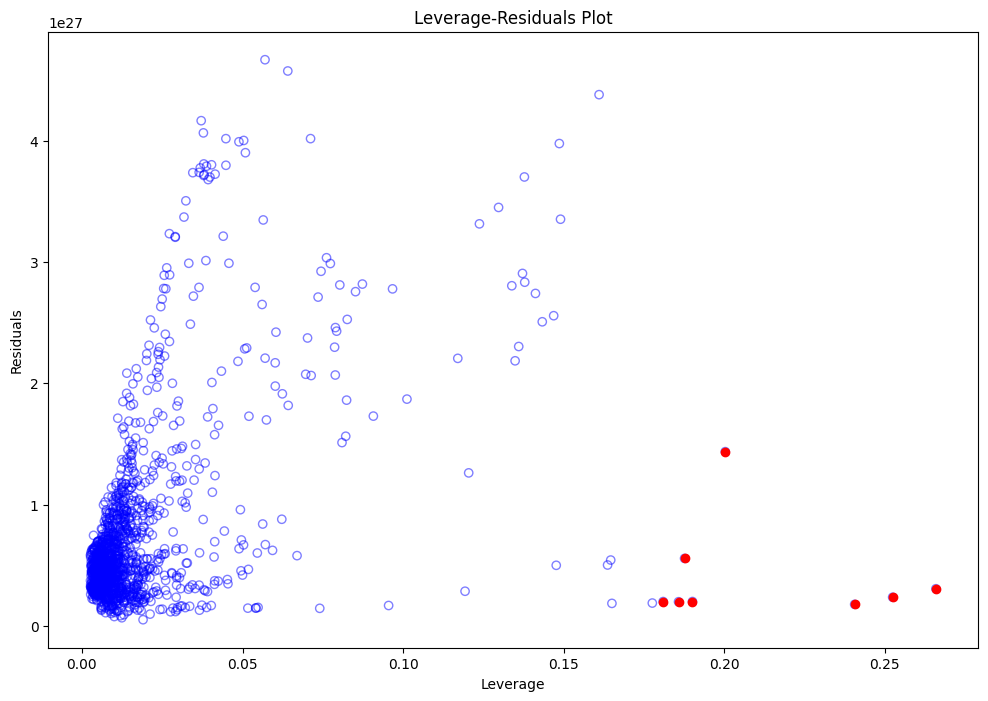

Successfully registered model 'FeOT_Low_outlier_removal'.
2023/12/05 15:07:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: FeOT_Low_outlier_removal, version 1
Created version '1' of model 'FeOT_Low_outlier_removal'.
2023/12/05 15:07:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 15:07:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:07:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:07:56 WARNING mlf

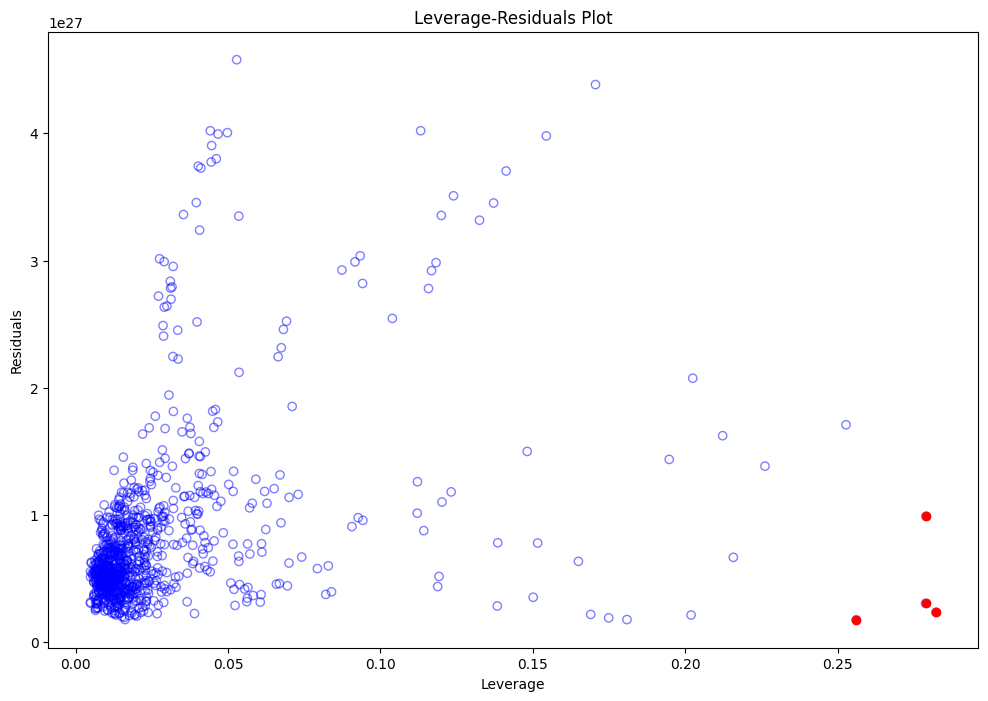

Successfully registered model 'FeOT_Mid_outlier_removal'.
2023/12/05 15:08:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: FeOT_Mid_outlier_removal, version 1
Created version '1' of model 'FeOT_Mid_outlier_removal'.
2023/12/05 15:08:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 15:08:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:08:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:08:48 WARNING mlf

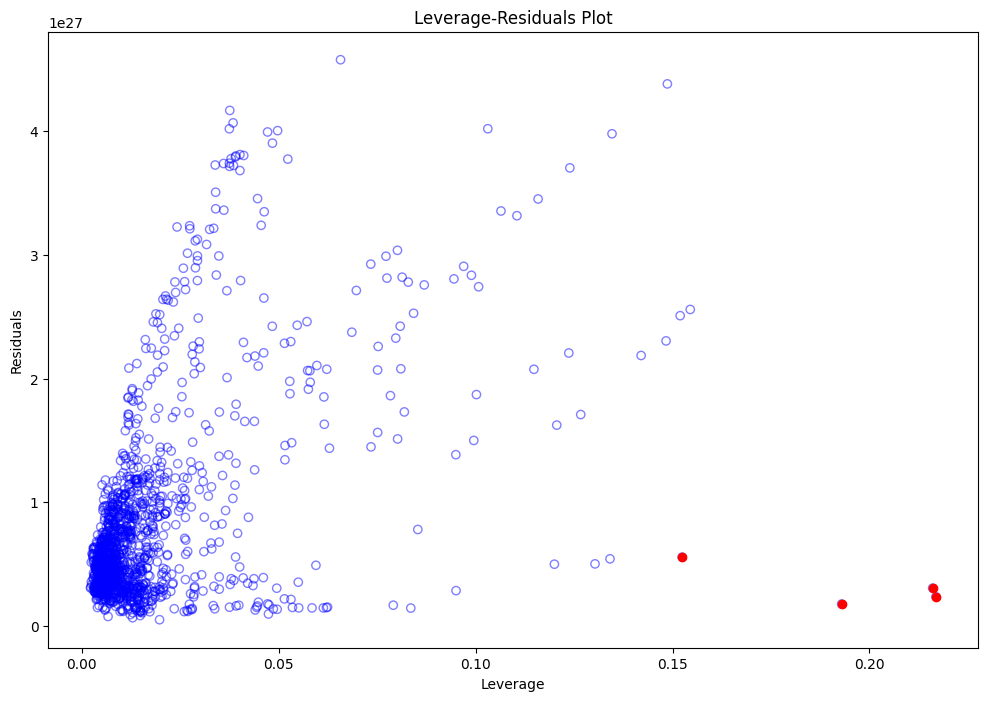

Successfully registered model 'MgO_Full_outlier_removal'.
2023/12/05 15:10:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: MgO_Full_outlier_removal, version 1
Created version '1' of model 'MgO_Full_outlier_removal'.
2023/12/05 15:10:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 15:10:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:10:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:10:26 WARNING mlf

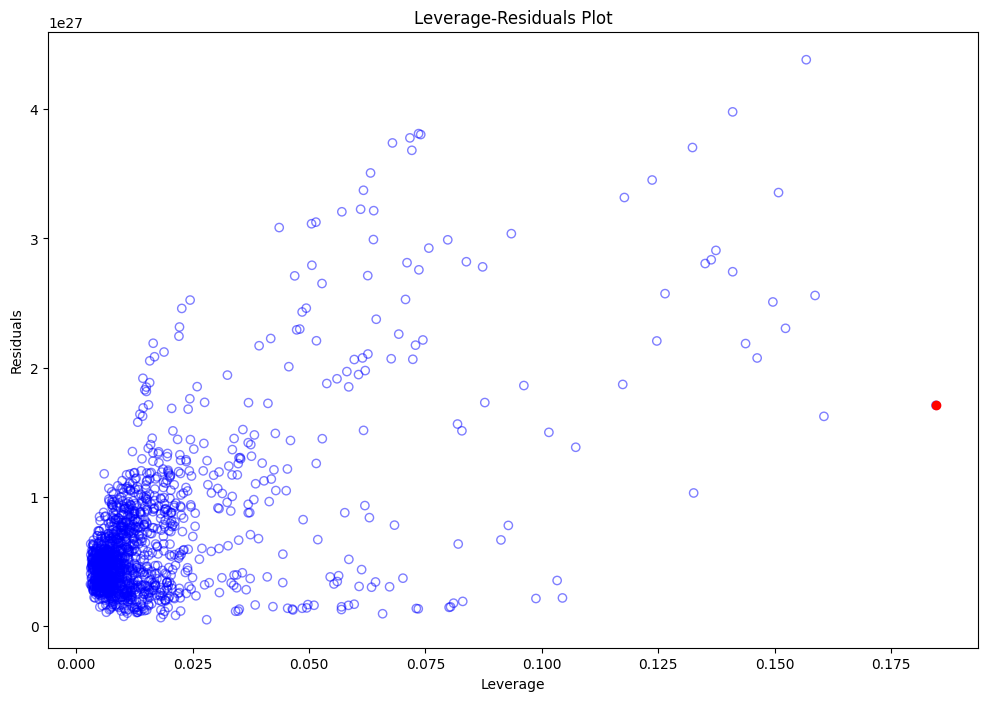

Successfully registered model 'MgO_Mid_outlier_removal'.
2023/12/05 15:12:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: MgO_Mid_outlier_removal, version 1
Created version '1' of model 'MgO_Mid_outlier_removal'.
2023/12/05 15:12:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 15:12:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:12:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:12:17 WARNING mlflow

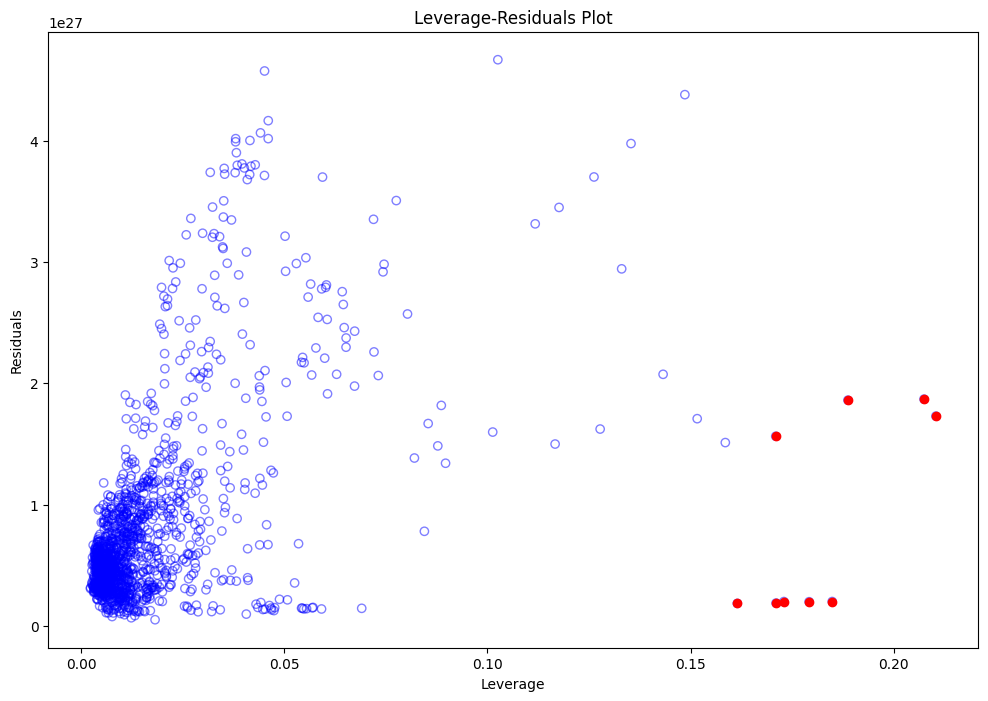

Successfully registered model 'CaO_Full_outlier_removal'.
2023/12/05 15:13:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: CaO_Full_outlier_removal, version 1
Created version '1' of model 'CaO_Full_outlier_removal'.
2023/12/05 15:13:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 15:13:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:13:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:13:55 WARNING mlf

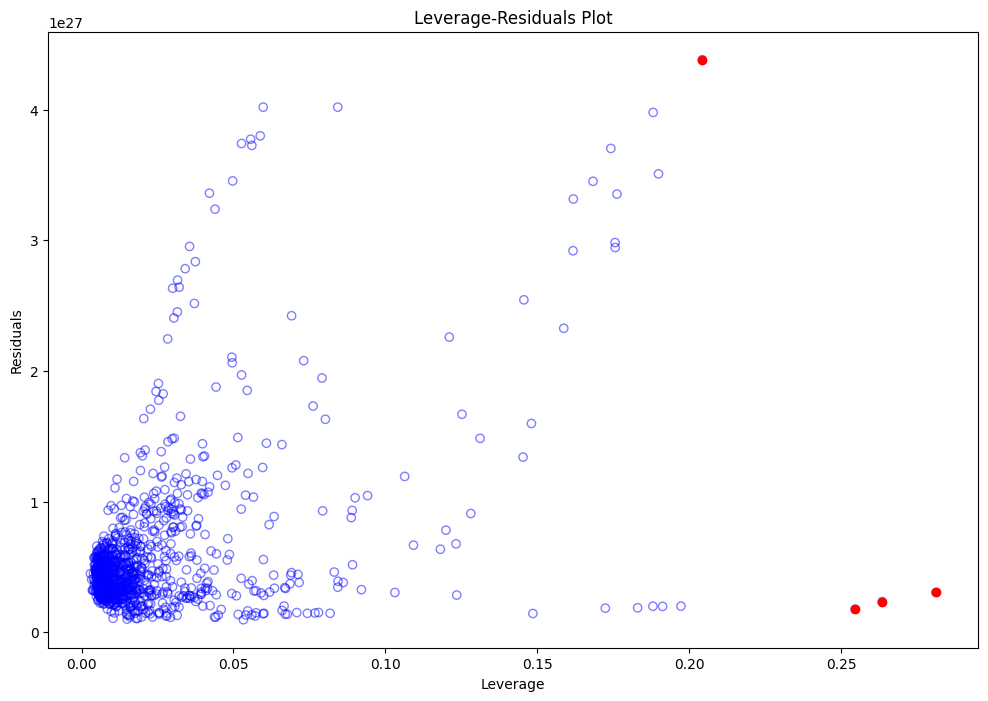

Successfully registered model 'CaO_Low_outlier_removal'.
2023/12/05 15:14:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: CaO_Low_outlier_removal, version 1
Created version '1' of model 'CaO_Low_outlier_removal'.
2023/12/05 15:14:44 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 15:14:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:14:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:14:54 WARNING mlflow

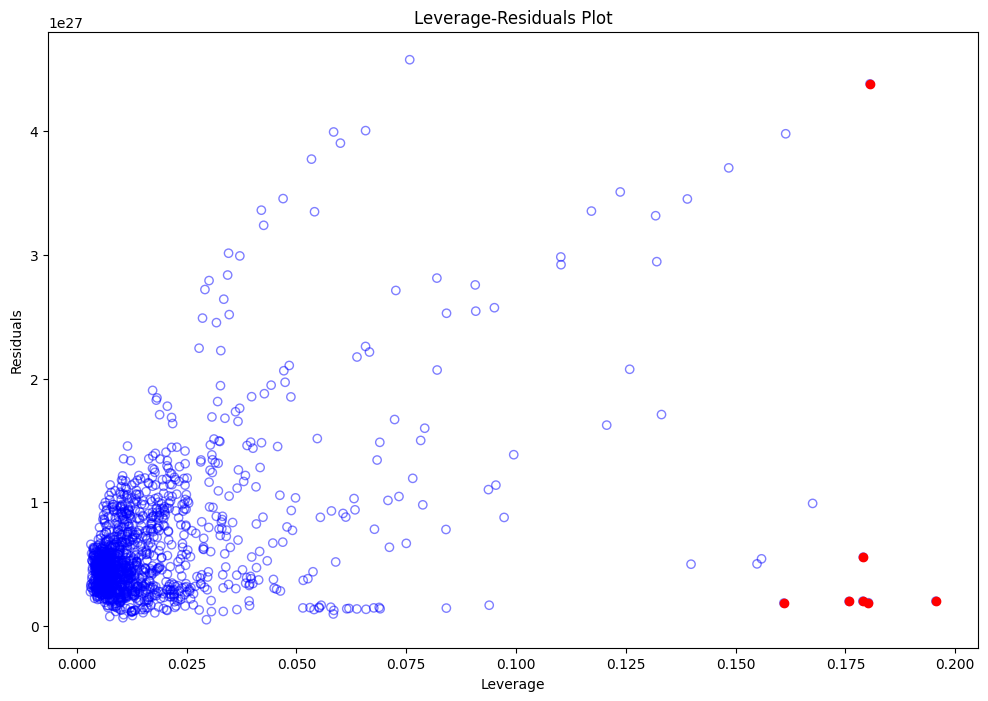

Successfully registered model 'CaO_Mid_outlier_removal'.
2023/12/05 15:15:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: CaO_Mid_outlier_removal, version 1
Created version '1' of model 'CaO_Mid_outlier_removal'.
2023/12/05 15:15:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 15:15:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:15:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:15:48 WARNING mlflow

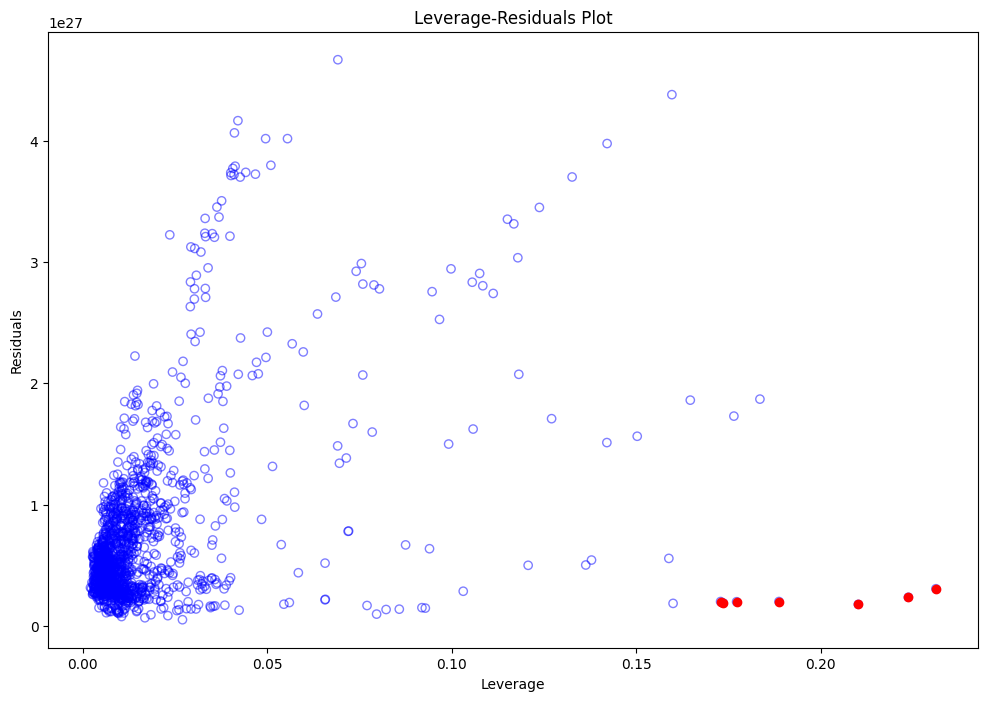

Successfully registered model 'Na2O_Full_outlier_removal'.
2023/12/05 15:17:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Na2O_Full_outlier_removal, version 1
Created version '1' of model 'Na2O_Full_outlier_removal'.
2023/12/05 15:17:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 15:17:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:17:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:17:26 WARNING 

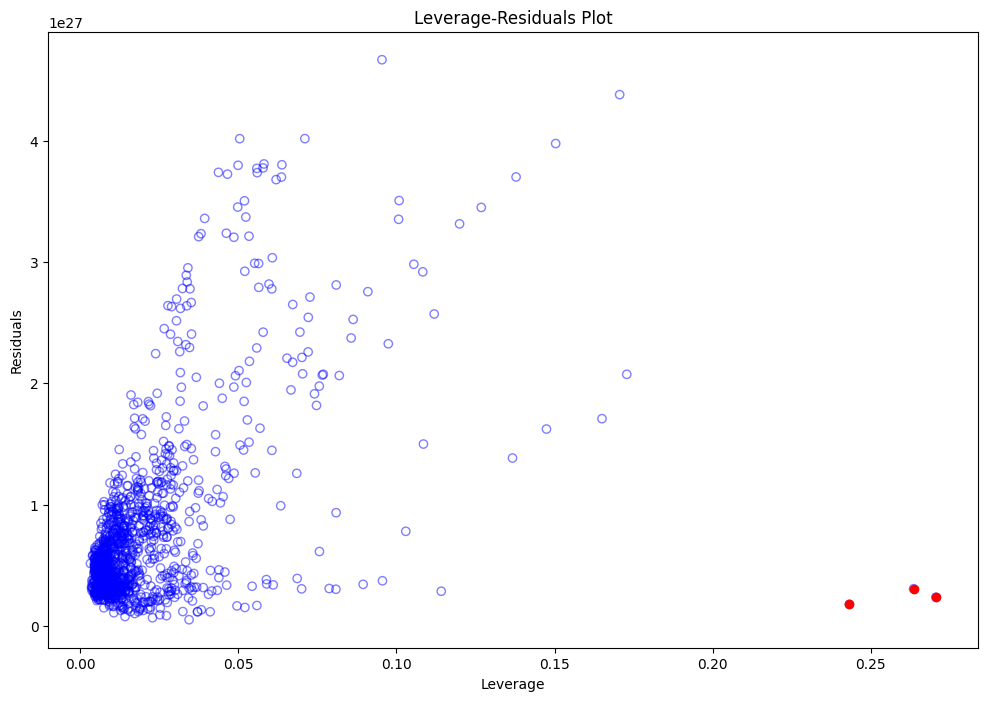

Successfully registered model 'Na2O_Low_outlier_removal'.
2023/12/05 15:18:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Na2O_Low_outlier_removal, version 1
Created version '1' of model 'Na2O_Low_outlier_removal'.
2023/12/05 15:18:14 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 15:18:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:18:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:18:21 WARNING mlf

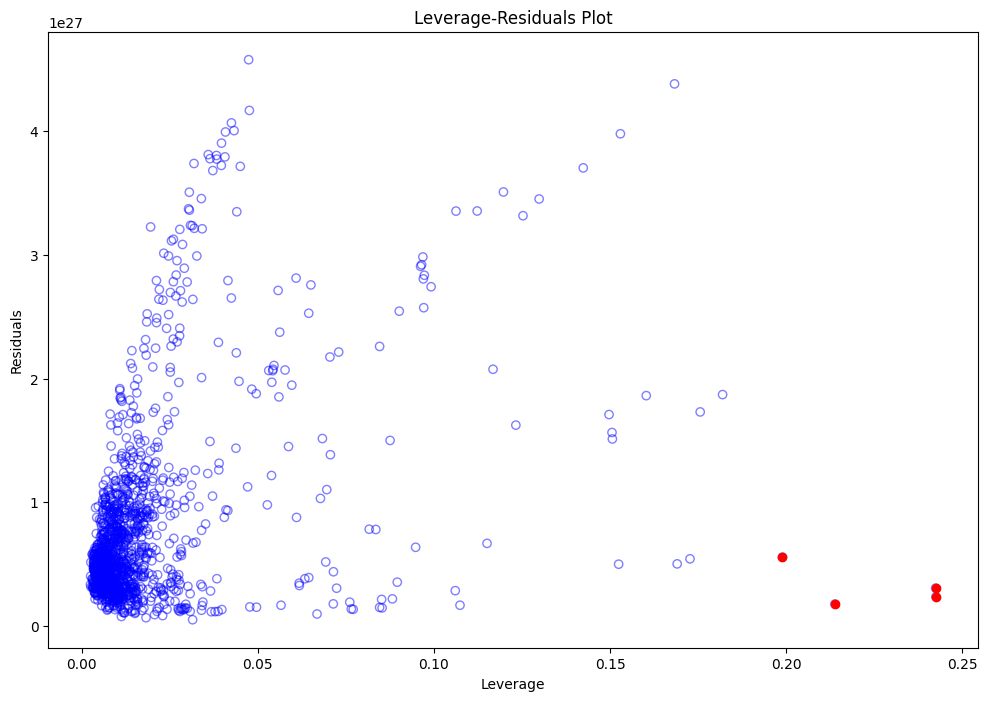

Successfully registered model 'K2O_Full_outlier_removal'.
2023/12/05 15:19:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: K2O_Full_outlier_removal, version 1
Created version '1' of model 'K2O_Full_outlier_removal'.
2023/12/05 15:19:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 15:19:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:19:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:20:00 WARNING mlf

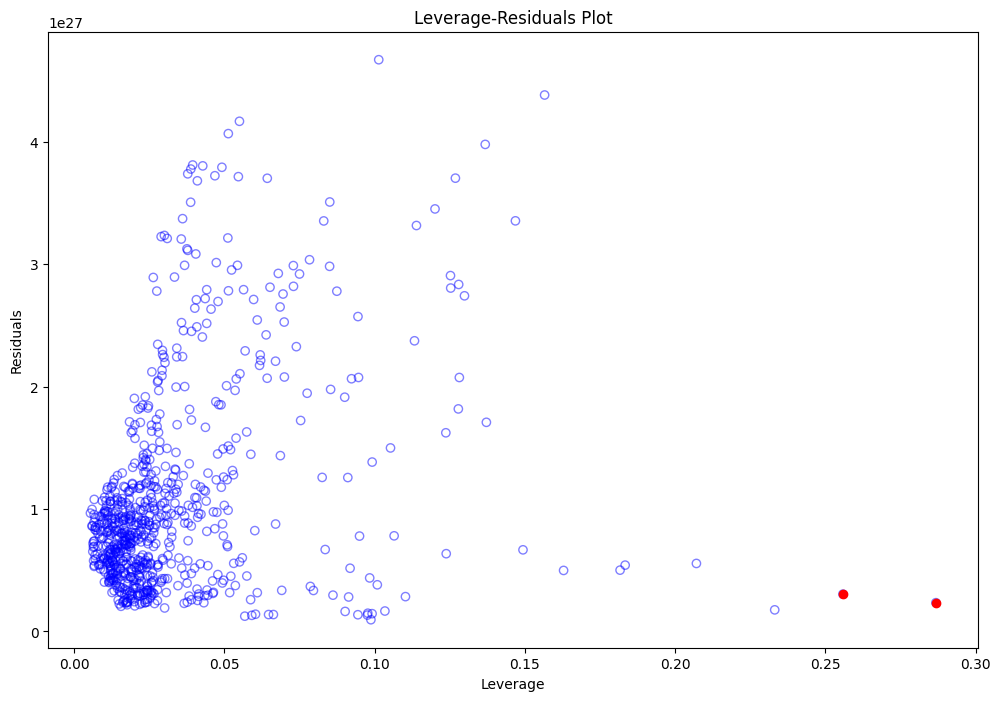

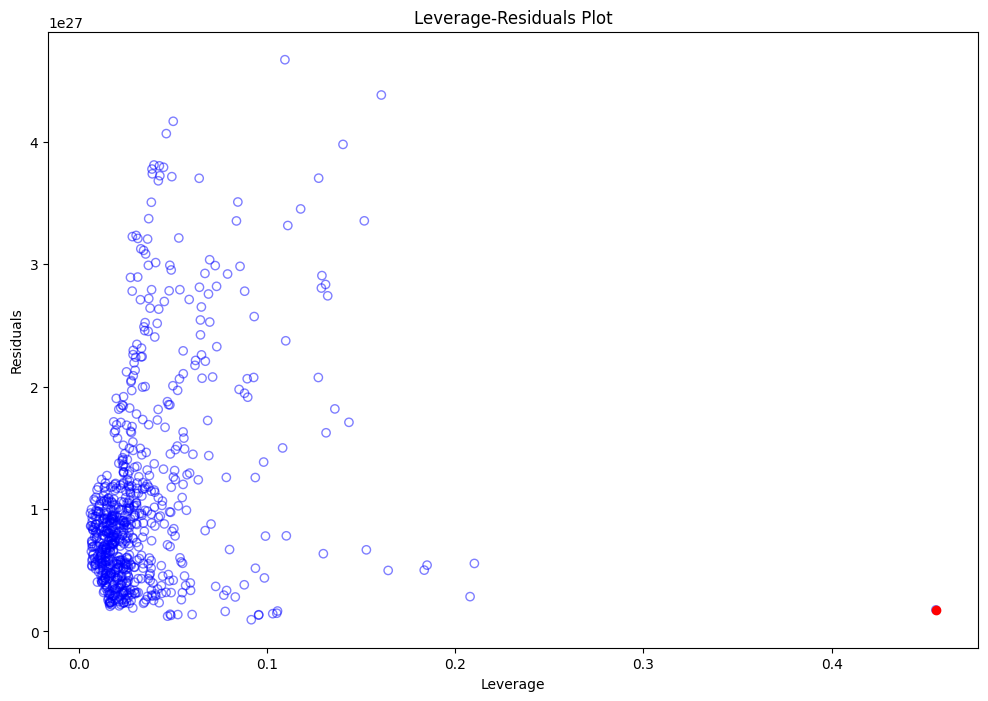

Successfully registered model 'K2O_Low_outlier_removal'.
2023/12/05 15:20:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: K2O_Low_outlier_removal, version 1
Created version '1' of model 'K2O_Low_outlier_removal'.
2023/12/05 15:20:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/05 15:20:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:20:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2023/12/05 15:20:50 WARNING mlflow

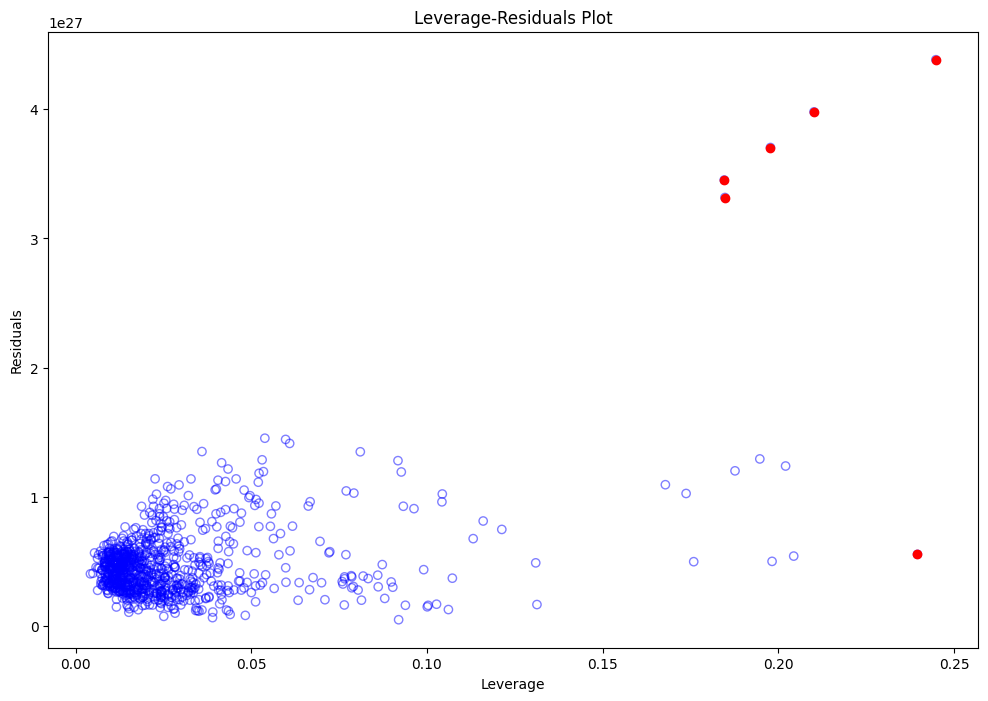

Successfully registered model 'K2O_High_outlier_removal'.
2023/12/05 15:21:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: K2O_High_outlier_removal, version 1
Created version '1' of model 'K2O_High_outlier_removal'.
Processing oxides: 100%|██████████| 8/8 [25:53<00:00, 194.14s/it]


In [11]:
from PLS_SM.outlier_removal import (
    calculate_leverage_residuals,
    identify_outliers,
    plot_leverage_residuals,
)


k_folds = 5
random_state = 42
n_components = 25  # paper said 20-30 TODO: grid search this
influence_plot_dir = Path("plots/")

experiment_name = f"PLS_Models_{pd.Timestamp.now().strftime('%m-%d-%y_%H%M%S')}"
mlflow.set_experiment(experiment_name)

for oxide in tqdm(major_oxides, desc="Processing oxides"):
    _oxide_ranges = oxide_ranges.get(oxide, None)
    if _oxide_ranges is None:
        logger.info("Skipping oxide: %s", oxide)
        continue

    for compositional_range in _oxide_ranges.keys():
        logger.debug(
            "Starting MLflow run for compositional range: %s, oxide: %s",
            compositional_range,
            oxide,
        )
        with mlflow.start_run(run_name=f"{oxide}_{compositional_range}"):
            best_model = None
            best_rmse = float("inf")
            mlflow.log_param("n_components", n_components)
            mlflow.log_param("random_state", random_state)
            logger.info("Filtering data by compositional range.")
            data_filtered = filter_data_by_compositional_range(
                processed_data, compositional_range, oxide, oxide_ranges
            )

            mlflow.autolog()

            train, test = custom_train_test_split(
                data_filtered,
                group_by="Sample Name",
                test_size=0.2,
                random_state=random_state,
            )

            logger.info("Performing custom k-fold cross-validation.")
            kf = custom_kfold_cross_validation(
                train,
                k=k_folds,
                group_by="Sample Name",
                random_state=random_state,
            )

            fold_rmse = []
            for i, (train_data, test_data) in enumerate(kf):
                logger.debug("Defining PLSRegression model.")
                pls = PLSRegression(
                    n_components=n_components
                )  # Adjust n_components as needed

                logger.debug("Extracting features and target for training.")
                X_train = train_data.drop(columns=major_oxides + ["Sample Name"])
                y_train = train_data[oxide]
                logger.debug("Extracting features and target for testing.")
                X_test = test_data.drop(columns=major_oxides + ["Sample Name"])
                y_test = test_data[oxide]

                logger.debug("Training the model.")
                pls.fit(X_train, y_train)
                logger.debug("Model training complete.")

                logger.debug("Predicting on test data.")
                y_pred = pls.predict(X_test)
                rmse = mean_squared_error(y_test, y_pred, squared=False)
                fold_rmse.append(rmse)
                logger.debug("Fold RMSE: %f", rmse)

                mlflow.log_metric(key=f"fold_{i}_rmse", value=float(rmse))

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = pls

            avg_rmse = sum(fold_rmse) / k_folds

            logger.debug("Logging parameters, metrics, and model to MLflow.")
            mlflow.log_params(
                {
                    "masks": masks,
                    "range": oxide_ranges[oxide][compositional_range],
                    "k_folds": k_folds,
                    "compositional_range": compositional_range,
                    "oxide": oxide,
                    "n_spectra": len(train),
                }
            )
            mlflow.log_metrics(
                {
                    "avg_rmse": float(avg_rmse),
                    "best_rmse": float(best_rmse),
                    "paper_rmse": paper_individual_sm_rmses[compositional_range][oxide],
                }
            )
            mlflow.sklearn.log_model(
                best_model,
                "model",
                registered_model_name=f"{oxide}_{compositional_range}",
            )

            # ----- Influence Plots for Outlier Removal ----- #

            mlflow.autolog()
            with mlflow.start_run(
                run_name=f"{oxide}_{compositional_range}_Outlier_Removal", nested=True
            ):
                outlier_removal_it = 0
                pls = PLSRegression(n_components=n_components)
                train_data = train.drop(columns=major_oxides + ["Sample Name"])
                X_train = train_data.to_numpy()
                Y_train = train[oxide].to_numpy()
                pls.fit(X_train, Y_train)

                initial_performance = mean_squared_error(
                    Y_train, pls.predict(X_train), squared=False
                )

                mlflow.log_metric(
                    "rmse", float(initial_performance), step=outlier_removal_it
                )

                while True:
                    outlier_removal_it += 1
                    leverage, Q = calculate_leverage_residuals(pls, X_train)
                    outliers = identify_outliers(leverage, Q)

                    if not np.any(outliers):
                        break

                    # Plotting the influence plot
                    plot_path = Path(
                        influence_plot_dir
                        / f"{experiment_name}/{oxide}_{compositional_range}_ip.png"
                    )
                    if not plot_path.parent.exists():
                        plot_path.parent.mkdir(parents=True)
                        
                    plot_leverage_residuals(leverage, Q, outliers, str(plot_path))

                    mlflow.log_artifact(str(plot_path))

                    # Removing the outliers
                    X_train = np.delete(X_train, outliers, axis=0)
                    Y_train = np.delete(Y_train, outliers, axis=0)

                    # Retraining the model
                    pls = PLSRegression(n_components=n_components)
                    pls.fit(X_train, Y_train)

                    # Logging the new performance
                    new_performance = mean_squared_error(
                        Y_train, pls.predict(X_train), squared=False
                    )
                    mlflow.log_metric(
                        "rmse", float(new_performance), step=outlier_removal_it
                    )
                    mlflow.log_metric(
                        "num_outliers", int(np.sum(outliers)), step=outlier_removal_it
                    )

                    if new_performance <= initial_performance:
                        break

                    initial_performance = new_performance

                mlflow.log_metric("outlier_removal_iterations", outlier_removal_it)
                mlflow.sklearn.log_model(
                    pls,
                    "model",
                    registered_model_name=f"{oxide}_{compositional_range}_outlier_removal",
                )

            logger.debug(
                "Compositional Range: %s, Oxide: %s, Average RMSE: %f",
                compositional_range,
                oxide,
                avg_rmse,
            )